In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
%matplotlib notebook

In [2]:
name = 'Esc3'
df = gpd.read_file('../data/interim/shapes/AP_Geotermica_' + name + '.shp')
df = df[df.geometry.notnull()].to_crs({'init': 'epsg:4326'}) 
print (len(df))

39


In [3]:
df.head()

,ID_N,CVE,NOMBRE,LONGITUD,LATITUD,TEMP,ENER_MIN,CAP_MIN,GEN_MIN,EMICO2_MIN,...,GEN_MED,EMICO2_MED,ENER_MAX,CAP_MAX,GEN_MAX,EMICO2_MAX,NOM_ENT,OC,NOM_MUN,geometry
0,1.0,1.0,Chiapas,-92.16,15.00,194.0,1.536950e+11,4.058584,32.019792,14.536985,...,64.039583,29.073971,4.610850e+11,12.175752,96.059375,43.610956,Chiapas,Cacahoatán (C),Cacahoatán,POINT (-92.16 15)
1,2.0,2.0,Chiapas,-92.08,15.06,159.0,6.252000e+10,1.650949,13.025000,5.913350,...,26.050000,11.826700,1.875600e+11,4.952848,39.075000,17.740050,Chiapas,Unión Juárez (C),Unión Juárez,POINT (-92.08 15.06)
2,3.0,3.0,Chiapas,-92.45,15.16,153.0,4.689000e+10,1.238212,9.768750,4.435013,...,19.537500,8.870025,1.406700e+11,3.714636,29.306250,13.305037,Chiapas,El Retiro (C),Huixtla,POINT (-92.45 15.16)
3,4.0,4.0,Chiapas,-92.20,15.20,194.0,1.536950e+11,4.058584,32.019792,14.536985,...,64.039583,29.073971,4.610850e+11,12.175752,96.059375,43.610956,Chiapas,Toquian (C),Tapachula,POINT (-92.2 15.2)
4,5.0,5.0,Chiapas,-92.33,15.31,194.0,1.536950e+11,4.058584,32.019792,14.536985,...,64.039583,29.073971,4.610850e+11,12.175752,96.059375,43.610956,Chiapas,Tolimán (C),Motozintla,POINT (-92.33 15.31)


In [4]:
states = gpd.read_file('../data/interim/shapes/mex-states.shp')
# Reproject the file
states = states.to_crs({'init': 'epsg:4326'}) 

In [5]:
import json, os
with open(os.path.join('../data/interim/', 'trans-regions.json'), 'r') as fp:
    trans_regions = json.load(fp)

In [6]:
loadzones = gpd.read_file('../data/interim/shapes/Mask_T.shp')
loadzones = loadzones.to_crs({'init': 'epsg:4326'}) 
loadzones['trans-region'] = loadzones['ID'].astype(int).map('{0:02}'.format).map(trans_regions)

In [7]:
loadzones.crs

{'init': 'epsg:4326'}

In [8]:
#loadzones.to_file("test.geojson", driver='GeoJSON')

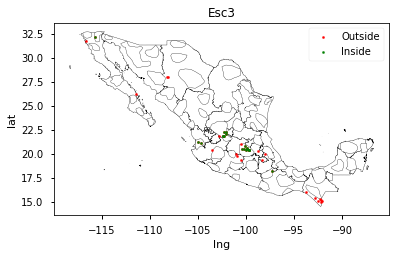

In [9]:
base = states.plot(color='white', edgecolor='black')
join = gpd.sjoin(df, loadzones, op='within')
#join = gpd.overlay(loadzones, df, how='intersection')
loadzones.plot(ax=base,color='white', edgecolor='black', label='Loadzones')
df.plot(color='red', ax=base, label='Outside', markersize=5)
#join.plot(ax=base, color='green', legend=True)
join.plot(ax=base, color='green', label='Inside', markersize=5)
plt.title(name)
plt.xlabel('lng')
plt.ylabel('lat')
plt.legend();
#plt.savefig(name + '.png', dpi=300)

In [10]:
from itertools import zip_longest

#join = gpd.sjoin(df, loadzones, op='within')
load_zones_out = loadzones[~loadzones['trans-region']
                          .isin(join['trans-region'].unique())]['trans-region']
load_zones_in = join.groupby('trans-region')['geometry'].count().index.values
#join = gpd.overlay(loadzones, df, how='intersection')
with open(name + '.txt', 'w') as fpd:
    fpd.write('Trans regions included:\t{0}\n'.format(len(join['trans-region'].unique())))
    fpd.write('Trans regions not included: \t{0}\n'
              .format(len(loadzones[~loadzones['trans-region']
                                    .isin(join['trans-region'].unique())])))
    fpd.write('Total points:\t{0}\n'.format(len(df)))
    fpd.write('Points inside:\t{0}\n'.format(len(join)))
    fpd.write('Points outside:\t{0}\n'.format(len(df) - len(join)))
    fpd.write('Trans_in\tTrans_out\n')
    for values in zip_longest(*[load_zones_in, load_zones_out]):
        fpd.write('{0}\t{1}\n'.format(values[0],values[1]))

In [11]:
no_1 = gpd.sjoin(df, loadzones, op='within')

In [12]:
grouped = no_1.groupby(['trans-region'])['ID'].count()

In [13]:
grouped

trans-region
22-tepic             2
24-aguascalientes    6
30-queretaro         9
34-puebla            1
48-mexicali          1
Name: ID, dtype: int64